In [1]:
from keras.layers import Conv2D, UpSampling2D, Input, Lambda, MaxPool2D, Reshape
from keras.models import Sequential, Model
# from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from keras.applications.vgg16 import VGG16
from skimage.color import rgb2lab, lab2rgb, gray2rgb
from skimage.transform import resize
from skimage.io import imsave
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import keras
import os

In [2]:
# HYPERPARAMETERS

TRAIN_EPOCHS: int = 10
IMAGE_SHAPE: tuple = (720, 1280)

In [3]:
# Define helper functions

def combine_l_ab(l: np.array, ab: np.array) -> np.array:
    ab = ab*128
    cur = np.zeros((IMAGE_SHAPE + (3,)))
    
    cur[:,:,0] = l[:, :, 0]
    cur[:,:,1:] = ab

    return cur

def display_img(img, gray = False): 
    cmap = 'gray' if gray else None
    plt.imshow(img, cmap=cmap) 
    plt.axis('off')  # Hide the axis
    plt.show()


In [4]:
# Define encoder

encoder_input_shape = (IMAGE_SHAPE + (3,)) # Add color dim to input shape
encoder: Model = VGG16(include_top=False, weights='imagenet', input_shape=encoder_input_shape)

# Freeze the pretrained layers
for layer in encoder.layers:
    layer.trainable = False

# Access the output shape of the encoder
encoder_output_shape = encoder.output_shape[1:] # Drop batch size element
print('VGG16-based encoder output shape: ' + str(encoder_output_shape))

# Display summary of encoder model
encoder.summary()

VGG16-based encoder output shape: (22, 40, 512)


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 720, 1280, 3)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 720, 1280, 64)  │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 720, 1280, 64)  │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 360, 640, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 360, 640, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 360, 640, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 180, 320, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 180, 320, 256)  │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 180, 320, 256)  │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 180, 320, 256)  │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 90, 160, 256)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 90, 160, 512)   │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 90, 160, 512)   │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 90, 160, 512)   │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 45, 80, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 45, 80, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 45, 80, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 45, 80, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 22, 40, 512)    │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

In [5]:
# Define decoder

decoder = Sequential(
    [
        Conv2D(256, (3,3), activation='relu', padding='same', input_shape=encoder_output_shape),
        Conv2D(128, (3,3), activation='relu', padding='same'),
        UpSampling2D((2, 2)),
        Conv2D(64, (3,3), activation='relu', padding='same'),
        UpSampling2D((2, 2)),
        Conv2D(32, (3,3), activation='relu', padding='same'),
        UpSampling2D((2, 2)),
        Conv2D(16, (3,3), activation='relu', padding='same'),
        UpSampling2D((2, 2)),
        Conv2D(2, (3, 3), activation='tanh', padding='same'),
        UpSampling2D((2, 2)),
        Lambda(lambda x: tf.image.resize(x, IMAGE_SHAPE, method=tf.image.ResizeMethod.BILINEAR))
    ],
    name='ColorizationDecoder'
)

# Access the output shape of the decoder
decoder_output_shape = decoder.output_shape[1:] # Drop batch size element
print('Decoder output shape: ' + str(decoder_output_shape))

decoder.summary()

Decoder output shape: (720, 1280, 2)


/Users/fsl/anaconda3/envs/cpsc542/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "ColorizationDecoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 22, 40, 256)    │     1,179,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 22, 40, 128)    │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 44, 80, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 44, 80, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 88, 160, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 88, 160, 32)    │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_2 (UpSampling2D)  │ (None, 176, 320, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 176, 320, 16)   │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_3 (UpSampling2D)  │ (None, 352, 640, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 352, 640, 2)    │           290 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_4 (UpSampling2D)  │ (None, 704, 1280, 2)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda (Lambda)                 │ (None, 720, 1280, 2)   │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,572,114 (6.00 MB)

 Trainable params: 1,572,114 (6.00 MB)

 Non-trainable params: 0 (0.00 B)

In [6]:
# Combine models??? ********

colorizer_model = Sequential(
    [
        encoder,
        decoder
    ]
)
colorizer_model.compile()
colorizer_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ ?                      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ ColorizationDecoder             │ ?                      │     1,572,114 │
│ (Sequential)                    │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,286,802 (62.13 MB)

 Trainable params: 1,572,114 (6.00 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [7]:
#  Generate data

import create_video as cc

data_path: str = './videos/'
frames: list = cc.process_video_frames(data_path=data_path, frame_skip=10)

len(frames)


Processing barbie.mp4... Storing every 10 frames
3865 total frames
Finished processing barbie.mp4. Exiting ...


387

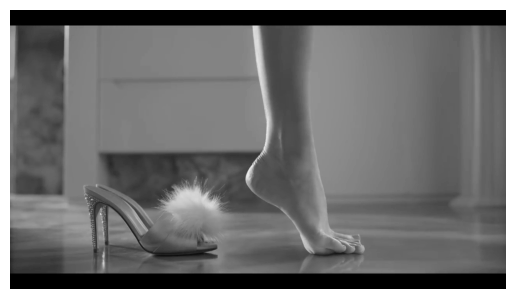

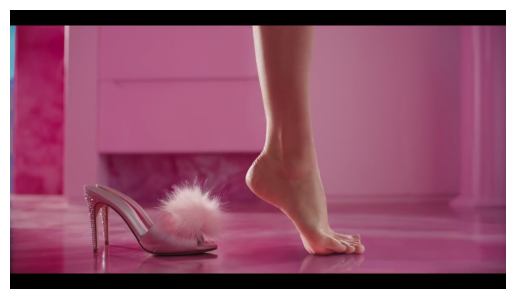

In [8]:
# Generated data contains tuple of images (rgb,grayscale) 
rgb_img, gray_img = frames[12]

# Take a look:
display_img(gray_img, gray=True)
display_img(rgb_img)


(387, 720, 1280, 1)
(387, 720, 1280, 2)


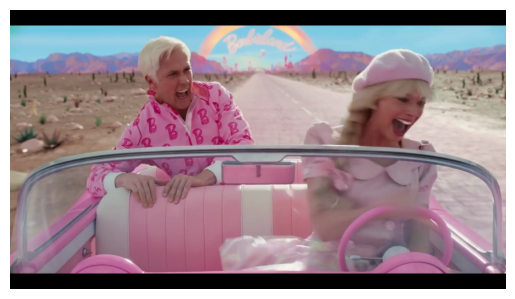

In [9]:
# Lets get to training these SOBs

train_l =[]
ground_truth_ab =[]
for rgb_img, gray_img in frames:
  try:
      lab = rgb2lab(rgb_img)
      train_l.append(lab[:,:,0]) 
      ground_truth_ab.append(lab[:,:,1:] / 128) #A and B values range from -127 to 128, 
      # divide the values by 128 to restrict values to between -1 and 1
  except:
     print('error')
train_l = np.array(train_l)
ground_truth_ab = np.array(ground_truth_ab)
train_l = train_l.reshape(train_l.shape+(1,)) #dimensions to be the same for X and Y

# Data shapes 
print(train_l.shape) # (N, H, W, 1)
print(ground_truth_ab.shape) # (N, H, W, 2)

# Combine L + AB to form color image
test_index = 200
l = train_l[test_index]
ab = ground_truth_ab[test_index]
cur = combine_l_ab(l,ab)

display_img(lab2rgb(cur)) # MatPlot expects RGB format

In [10]:
#one channel of L in each layer but, VGG16 is expecting 3 dimension, 
#so repeat the L channel two times to get 3 dimensions of the same L channel

encoder_features = []
for i, sample in enumerate(train_l):
  sample = gray2rgb(sample) 
  sample = sample.reshape(((1,) + IMAGE_SHAPE + (3,)))
  prediction = encoder.predict(sample)
  prediction = prediction.reshape(encoder_output_shape)
  encoder_features.append(prediction)
encoder_features = np.array(encoder_features)
print(encoder_features.shape)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 

In [12]:
decoder.compile(optimizer='Adam', loss='mse' , metrics=['accuracy'])
decoder.fit(encoder_features, ground_truth_ab, verbose=1, epochs=10, batch_size=128)
# decoder.save('colorize_autoencoder_VGG16.model')


Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 25s 5s/step - accuracy: 0.7792 - loss: 0.0168
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 23s 5s/step - accuracy: 0.5517 - loss: 0.0153
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 24s 5s/step - accuracy: 0.7793 - loss: 0.0139
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 26s 5s/step - accuracy: 0.7953 - loss: 0.0126
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 24s 5s/step - accuracy: 0.7903 - loss: 0.0106
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 23s 5s/step - accuracy: 0.7854 - loss: 0.0104
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 24s 5s/step - accuracy: 0.7932 - loss: 0.0107
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 23s 5s/step - accuracy: 0.7941 - loss: 0.0097
Epoch 9/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 22s 5s/step - accuracy: 0.7725 - loss: 0.0094
Epoch 10/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 24s 5s/step - accuracy: 0.7700 - loss: 0.0092


In [21]:
decoder.save('colorize_decoder.keras')

In [44]:
#Predicting using saved model.

import cv2

testpath = './images/parasite.png'

testing = np.array(cv2.imread(testpath))

testing_lab = rgb2lab(testing)
l = testing_lab[:,:,0]
l_input = gray2rgb(l).reshape(((1,) + IMAGE_SHAPE + (3,)))
# display_img(l, gray=True)

bottleneck = encoder.predict(l_input)

# files = os.listdir(testpath)
# print(files)
# for idx, file in enumerate(files):
#     test = cv2.imread(testpath+file)
#     # test*= 1.0/255
#     lab = rgb2lab(test)
#     l = lab[:,:,0]
#     L = gray2rgb(l)
#     # L = L.reshape((1,224,224,3))
#     #print(L.shape)
#     # vggpred = encoder.predict(np.array(L))
#     # ab = decoder.predict(vggpred)
#     # #print(ab.shape)
#     # # ab = ab*128
#     # cur = combine_l_ab(l,ab)

#     display_img(L)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


In [35]:
output = decoder.predict(bottleneck)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


In [48]:
print(testing_lab[:,:,:1].shape)
output.shape

(720, 1280)


(1, 720, 1280, 2)

In [39]:
cur = combine_l_ab(l,output)

display_img(lab2rgb(cur)) # MatPlot expects RGB format

IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed